# Finding Lane Lines on the Road

## Import Packages

In [83]:
# importing libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import glob
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


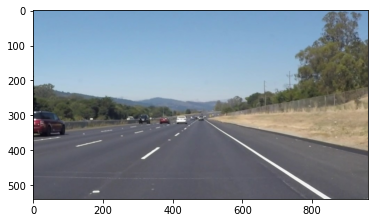

In [2]:
# reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [240]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    right_lines = [] # a tuple of m and b in y = mx + b for each line
    left_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1)) > 0:
                right_lines.append(((y2-y1)/(x2-x1), y1 - ((y2-y1)/(x2-x1)) * x1))
            else:
                left_lines.append(((y2-y1)/(x2-x1), y1 - ((y2-y1)/(x2-x1)) * x1))
    
    y_bottom = img.shape[0]
    y_top = img.shape[0] // 2 + 60
    if right_lines:
        right_params = np.array(right_lines).mean(axis = 0)
        cv2.line(img, 
             (int((y_bottom - right_params[1])/right_params[0]), y_bottom), 
             (int((y_top - right_params[1])/right_params[0]), y_top), color, thickness)
    
    if left_lines:
        left_params = np.array(left_lines).mean(axis = 0)
        cv2.line(img, 
             (int((y_bottom - left_params[1])/left_params[0]), y_bottom), 
             (int((y_top - left_params[1])/left_params[0]), y_top), color, thickness)
    
    # Can switch to these lines to visualize raw hough lines    
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 2)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline

In [187]:
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

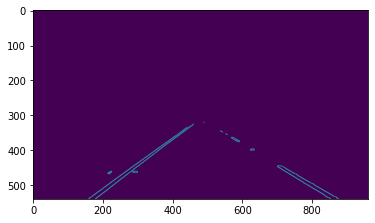

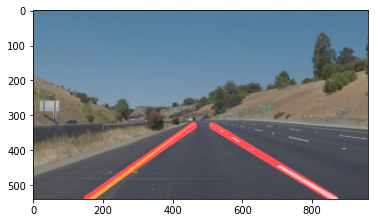

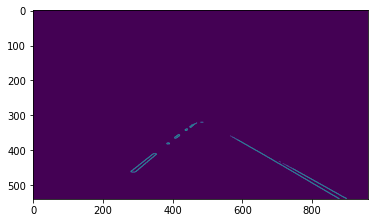

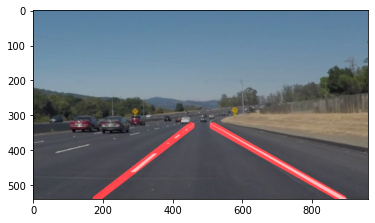

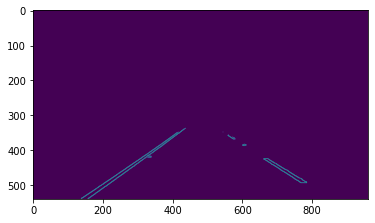

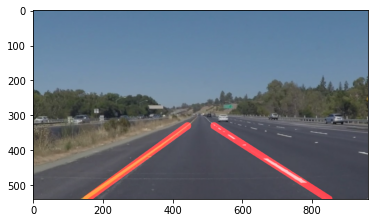

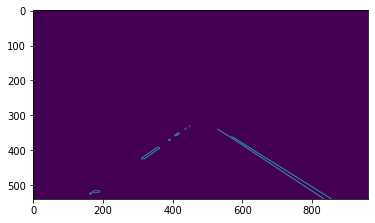

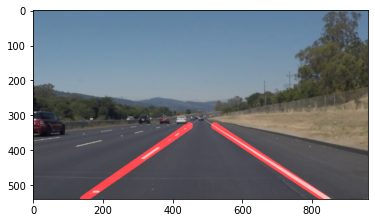

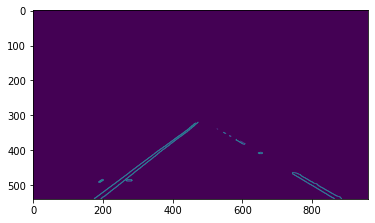

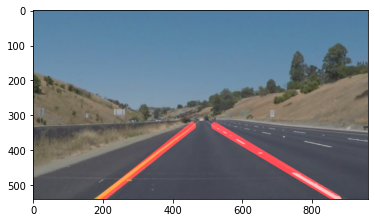

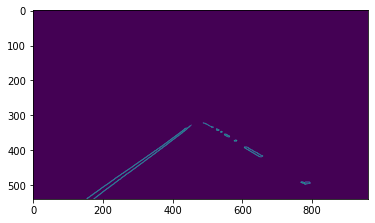

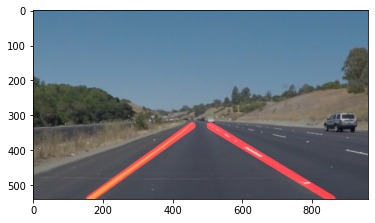

In [199]:
for img_file in glob.glob("test_images/*.jpg"):

    img = mpimg.imread(img_file)

    img_shape = img.shape

    img_gray = grayscale(img)

    kernel_size = 5
    img_blur = gaussian_blur(img_gray, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(img_blur, low_threshold, high_threshold)

    vertices = np.array([[(50,img_shape[0]),(img_shape[1]//2 -10, img_shape[0]//2 + 50), (img_shape[1]//2 + 10, img_shape[0]//2 + 50), (img_shape[1]-50,img_shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    plt.imshow(masked_edges)
    plt.show()

    rho = 5
    theta = np.pi/180
    threshold = 100
    min_line_length = 100
    max_line_gap = 200
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    final_img = weighted_img(lines, img)

    plt.imshow(final_img)
    plt.show()
    cv2.imwrite('test_images_output/' + img_file[12:-4] + '_result.jpg',final_img)


## Test on Videos

In [106]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [241]:
def process_image(image):
    
    img_shape = image.shape

    img_gray = grayscale(image)

    kernel_size = 5
    img_blur = gaussian_blur(img_gray, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(img_blur, low_threshold, high_threshold)

    vertices = np.array([[(50,img_shape[0]),(img_shape[1]//2 -10, img_shape[0]//2 + 50), (img_shape[1]//2 + 10, img_shape[0]//2 + 50), (img_shape[1]-50,img_shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 5
    theta = np.pi/180
    threshold = 100
    min_line_length = 100
    max_line_gap = 200
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    final_img = weighted_img(lines, image)
    return final_img

Let's try the one with the solid white lane on the right first ...

In [242]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

                                                              
t:  35%|███▌      | 78/221 [22:32<00:01, 118.45it/s, now=None]
                                                              
t:  42%|████▏     | 53/125 [02:58<00:00, 120.61it/s, now=None]

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

t:   9%|▉         | 20/221 [00:00<00:01, 197.03it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4





t:  18%|█▊        | 40/221 [00:00<00:00, 189.93it/s, now=None]

t:  27%|██▋       | 60/221 [00:00<00:01, 125.05it/s, now=None]

t:  34%|███▍      | 75/221 [00:00<00:01, 124.96it/s, now=None]

t:  40%|████      | 89/221 [00:00<00:01, 127.81it/s, now=None]

t:  47%|████▋     | 104/221 [00:00<00:00, 130.99it/s, now=None]

t:  53%|█████▎    | 118/221 [00:00<00:00, 131.28it/s, now=None]

t:  60%|█████▉    | 132/221 [00:00<00:00, 130.48it/s, now=None]

t:  66%|██████▌   | 146/221 [00:01<00:00, 127.93it/s, now=None]

t:  72%|███████▏  | 160/221 [00:01<00:00, 130.56it/s, now=None]

t:  79%|███████▊  | 174/221 [00:01<00:00, 130.46it/s, now=None]

t:  85%|████████▌ | 188/221 [00:01<00:00, 128.61it/s, now=None]

t:  91%|█████████ | 201/221 [00:01<00:00, 126.91it/s, now=None]

t:  98%|█████████▊| 216/221 [00:01<00:00, 131.40it/s, now=None]

                                                               
t:  35%|███▌      | 78/221 [22:34<00:01, 118.45it/s, now=None]
                              

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 2.3 s, sys: 2.51 s, total: 4.81 s
Wall time: 1.95 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [243]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [244]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

                                                              
t:  35%|███▌      | 78/221 [22:46<00:01, 118.45it/s, now=None]
                                                              
t:  42%|████▏     | 53/125 [03:12<00:00, 120.61it/s, now=None]

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

t:   3%|▎         | 18/681 [00:00<00:03, 178.48it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4





t:   5%|▌         | 37/681 [00:00<00:03, 185.21it/s, now=None]

t:   8%|▊         | 56/681 [00:00<00:04, 134.83it/s, now=None]

t:  10%|█         | 71/681 [00:00<00:04, 132.27it/s, now=None]

t:  12%|█▏        | 85/681 [00:00<00:04, 132.10it/s, now=None]

t:  15%|█▍        | 99/681 [00:00<00:04, 131.65it/s, now=None]

t:  17%|█▋        | 113/681 [00:00<00:04, 130.47it/s, now=None]

t:  19%|█▉        | 128/681 [00:00<00:04, 132.68it/s, now=None]

t:  21%|██        | 142/681 [00:01<00:04, 128.30it/s, now=None]

t:  23%|██▎       | 155/681 [00:01<00:04, 122.75it/s, now=None]

t:  25%|██▍       | 169/681 [00:01<00:04, 126.65it/s, now=None]

t:  27%|██▋       | 182/681 [00:01<00:03, 127.18it/s, now=None]

t:  29%|██▊       | 195/681 [00:01<00:03, 122.15it/s, now=None]

t:  31%|███       | 208/681 [00:01<00:03, 123.15it/s, now=None]

t:  32%|███▏      | 221/681 [00:01<00:03, 119.32it/s, now=None]

t:  35%|███▍      | 235/681 [00:01<00:03, 123.86it/s, now=None]

t:  36%|███▋      | 248/681 

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 7.62 s, sys: 7.55 s, total: 15.2 s
Wall time: 5.62 s


In [245]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))